# 1. Setup

## 1.1 Install Dependencies

In [1]:
!pip install tensorflow opencv-python matplotlib


[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1.2 Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [5]:
!pip install kagglehub



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

print("Path to dataset files:", path)

C:\Facial verification\FaceRecognition\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|█████████████████████████████████████████████████████████████████████████████████████████| 112M/112M [00:04<00:00, 28.6MB/s]

Extracting files...


Path to dataset files: C:\Users\MHH\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4


In [12]:
import os

# Correct local path
data_path = r'C:\Users\MHH\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled'

# Print first 10 folders to verify
print(os.listdir(data_path)[:10])


['lfw-deepfunneled']


In [13]:
import os
import shutil

# ✅ Use your correct local Windows path:
data_path = r'C:\Users\MHH\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled'

NEG_PATH = 'data/negative'
os.makedirs(NEG_PATH, exist_ok=True)

# Verify the structure again
print("First few folders:", os.listdir(data_path)[:5])

# Copy images instead of moving
for person in os.listdir(data_path):
    person_dir = os.path.join(data_path, person)
    if os.path.isdir(person_dir):
        for img_file in os.listdir(person_dir):
            src_path = os.path.join(person_dir, img_file)
            dst_path = os.path.join(NEG_PATH, img_file)
            shutil.copy(src_path, dst_path)

print(f"✅ Images copied successfully to {NEG_PATH}")
print(f"Total images copied: {len(os.listdir(NEG_PATH))}")


First few folders: ['Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena']
✅ Images copied successfully to data/negative
Total images copied: 13233


## 2.2 Collect Positive and Anchor Classes

In [21]:
# Import uuid library to generate unique image names
import uuid

In [22]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor\\67c2d49d-23e7-11f0-8820-181dea9de125.jpg'

In [23]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

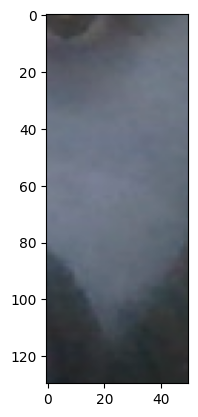

In [12]:
plt.imshow(frame[120:120+250,200:200+250, :])

# 2.x NEW - Data Augmentation

In [151]:
def data_aug(img):
    img = tf.cast(img, tf.float32) / 255.0  # FIX 1: normalize before augmentation
    data = []
    for i in range(9):
        aug_img = img
        aug_img = tf.image.stateless_random_brightness(aug_img, max_delta=0.2, seed=(1,2))
        aug_img = tf.image.stateless_random_contrast(aug_img, lower=0.7, upper=1.3, seed=(1,3))
        aug_img = tf.image.stateless_random_flip_left_right(aug_img, seed=(np.random.randint(100), np.random.randint(100)))
        aug_img = tf.image.stateless_random_jpeg_quality(aug_img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100), np.random.randint(100)))
        aug_img = tf.image.stateless_random_saturation(aug_img, lower=0.8, upper=1.2, seed=(np.random.randint(100), np.random.randint(100)))
        
        data.append(aug_img)
    
    return data


In [153]:
import os
import uuid

In [154]:
img_path = os.path.join(ANC_PATH, 'c274ed66-23ca-11f0-864f-181dea9de125.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [156]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

KeyboardInterrupt: 

In [157]:
for image in augmented_images:
    image = (image * 255).numpy().astype('uint8')  # FIX 2: Convert back to uint8
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image)


# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [24]:
anchor = tf.data.Dataset.list_files(rf'{ANC_PATH}\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(rf'{POS_PATH}\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(rf'{NEG_PATH}\*.jpg').take(3000)


In [25]:
dir_test = anchor.as_numpy_iterator()

In [26]:
print(dir_test.next())

b'data\\anchor\\d889feea-23cd-11f0-b371-181dea9de125.jpg'


## 3.2 Preprocessing - Scale and Resize

In [27]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [28]:
ANC_PATH = 'data/anchor'  # Your anchor folder path
dataset = tf.data.Dataset.list_files(f'{ANC_PATH}/*.jpg')


In [29]:
dataset = dataset.map(preprocess)


## 3.3 Create Labelled Dataset

In [30]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [31]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [32]:
samples = data.as_numpy_iterator()

In [33]:
exampple = samples.next()

In [34]:
exampple

(b'data\\anchor\\99331a50-23e7-11f0-a5f2-181dea9de125.jpg',
 b'data\\positive\\09bcec10-23e8-11f0-82b2-181dea9de125.jpg',
 np.float32(1.0))

## 3.4 Build Train and Test Partition

In [35]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [36]:
res = preprocess_twin(*exampple)

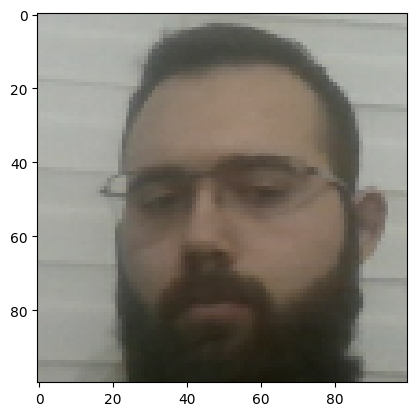

In [37]:
plt.imshow(res[1])

In [38]:
res[2]

np.float32(1.0)

In [39]:
import tensorflow as tf

def preprocess(file_or_img):
    if isinstance(file_or_img, tf.Tensor) and file_or_img.dtype == tf.string:
        byte_img = tf.io.read_file(file_or_img)
        img = tf.io.decode_jpeg(byte_img)
    else:
        img = file_or_img

    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img


In [40]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)


In [41]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [42]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [43]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [44]:
inp = Input(shape=(100,100,3), name='input_image')

In [45]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [46]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [47]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [48]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [49]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [50]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [51]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [53]:
embedding = make_embedding()

In [54]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [55]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [56]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [57]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [58]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [59]:
siamese_layer = L1Dist()

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

embedding = Sequential([
    Input(shape=(100, 100, 3)),   # Explicit Input layer
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(4096, activation='sigmoid')
])


In [61]:
from tensorflow.keras.layers import Layer

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Create inputs
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

# Pass through embedding
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

# Calculate L1 distance
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)

print(distances)



<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_29>


In [62]:
output = Dense(1, activation='sigmoid')(distances)
siamese_model = tf.keras.Model(inputs=[input_image, validation_image], outputs=output)


In [63]:
classifier = Dense(1, activation='sigmoid')(distances)

In [64]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_31>

In [65]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [66]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 4096)              │     277,428,096 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (None, 4096)              │               0 │ sequential[0][0],          │
│                               │                           │                 │ sequential[1][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 277,432,193 (1.03 GB)

 Trainable params: 277,432,193 (1.03 GB)

 Non-trainable params: 0 (0.00 B)

In [67]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [68]:
siamese_model = make_siamese_model()

In [69]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 4096)              │     277,428,096 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_3 (L1Dist)            │ (None, 4096)              │               0 │ sequential[2][0],          │
│                               │                           │                 │ sequential[3][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 277,432,193 (1.03 GB)

 Trainable params: 277,432,193 (1.03 GB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [70]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [71]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [72]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [73]:
test_batch = train_data.as_numpy_iterator()

In [74]:
batch_1 = test_batch.next()

In [75]:
X = batch_1[:2]

In [76]:
y = batch_1[2]

In [77]:
y

array([1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

In [78]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [79]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [80]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [81]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [82]:
EPOCHS = 50

In [83]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235m

# 6. Evaluate Model

## 6.1 Import Metrics

In [124]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [125]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [126]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


In [127]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]

In [128]:
y_true

array([0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [129]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [130]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [131]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1.0 1.0


## 6.4 Viz Results

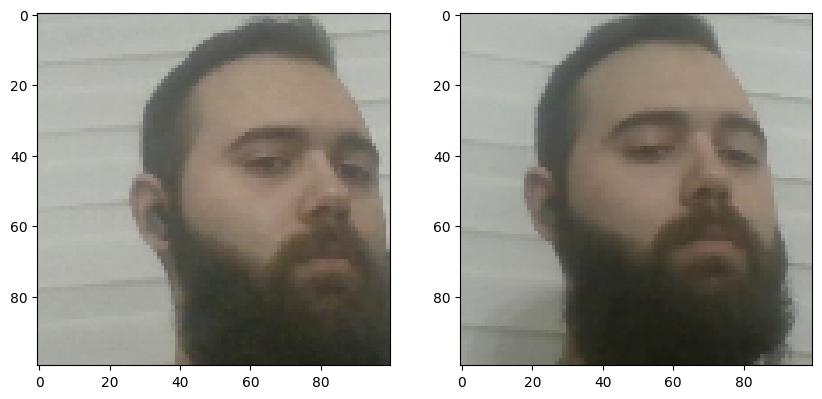

In [134]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

# 7. Save Model

In [95]:
# Save weights
siamese_model.save('mimo123.keras')

In [96]:
L1Dist

__main__.L1Dist

In [97]:
# Reload model 
siamese_model = tf.keras.models.load_model('mimo.keras', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [98]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


array([[9.9999851e-01],
       [9.9999994e-01],
       [1.4657798e-11],
       [9.6724693e-07],
       [3.2548460e-08]], dtype=float32)

In [99]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 4096)              │     277,428,096 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_4 (L1Dist)            │ (None, 4096)              │               0 │ sequential[0][0],          │
│                               │                           │                 │ sequential[1][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_4[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 277,432,193 (1.03 GB)

 Trainable params: 277,432,193 (1.03 GB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [141]:
FaceIDApp\application_data\verification_images

SyntaxError: unexpected character after line continuation character (3469989548.py, line 1)

In [143]:
import os

# Move to project directory
os.chdir('C:/Facial verification/FaceRecognition/FaceIDApp')

# Now use relative path
files = os.listdir(os.path.join('application_data', 'verification_images'))

print(f"Total images: {len(files)}")
print(files[:5])


Total images: 50
['c01703e8-135f-11ec-9c58-a0cec8d2d278.jpg', 'c08e1f2e-135f-11ec-ab18-a0cec8d2d278.jpg', 'c099e9f0-135f-11ec-86a7-a0cec8d2d278.jpg', 'c0c715c0-135f-11ec-892f-a0cec8d2d278.jpg', 'c0ef7814-135f-11ec-904e-a0cec8d2d278.jpg']


In [144]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [145]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\c01703e8-135f-11ec-9c58-a0cec8d2d278.jpg
application_data\verification_images\c08e1f2e-135f-11ec-ab18-a0cec8d2d278.jpg
application_data\verification_images\c099e9f0-135f-11ec-86a7-a0cec8d2d278.jpg
application_data\verification_images\c0c715c0-135f-11ec-892f-a0cec8d2d278.jpg
application_data\verification_images\c0ef7814-135f-11ec-904e-a0cec8d2d278.jpg
application_data\verification_images\c202065a-135f-11ec-b0bc-a0cec8d2d278.jpg
application_data\verification_images\c22117d0-135f-11ec-926e-a0cec8d2d278.jpg
application_data\verification_images\c268919e-135f-11ec-bd66-a0cec8d2d278.jpg
application_data\verification_images\c2a3a158-135f-11ec-99bc-a0cec8d2d278.jpg
application_data\verification_images\c2afbad2-135f-11ec-b848-a0cec8d2d278.jpg
application_data\verification_images\c2e6ebc6-135f-11ec-911c-a0cec8d2d278.jpg
application_data\verification_images\c3aedf8a-135f-11ec-8753-a0cec8d2d278.jpg
application_data\verification_images\c3c988f4-135f-11ec-9c57-a0c

In [146]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [147]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [150]:
results = None  # Initialize before the loop!

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Now results exists safely
if results is not None:
    print(np.sum(np.squeeze(results) > 0.9))
else:
    print('⚠️ No verification was run yet!')


KeyboardInterrupt: 

In [151]:
results